In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

import h5py
import hdf5plugin

In [3]:
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

In [4]:
file_list = [
    'train_cite_inputs.h5',
    'train_cite_targets.h5',
    'train_multi_inputs.h5',
    'train_multi_targets.h5',
    'test_cite_inputs.h5',
    'test_multi_inputs.h5'
    ]
for f in file_list:
  f_path = f'/Users/tele/open-problems-multimodal/{f}'
  f_size = os.path.getsize(f_path)
  f_size_converted = convert_bytes(f_size)
  print(f'{f} :', f_size_converted)

train_cite_inputs.h5 : 2.3 GB
train_cite_targets.h5 : 36.8 MB
train_multi_inputs.h5 : 10.6 GB
train_multi_targets.h5 : 3.0 GB
test_cite_inputs.h5 : 1.6 GB
test_multi_inputs.h5 : 6.0 GB


In [5]:
def load_h5_data(file):
    path = f'/Users/tele/open-problems-multimodal/{file}'
    f = h5py.File(path, 'r')
    group = f[file[:-3]]

    data = group['block0_values']

    return data

In [23]:
def return_h5_path(file):
    path = f'/Users/tele/open-problems-multimodal/{file}'
    return path

In [24]:
train_cite_inputs_data = load_h5_data('train_cite_inputs.h5')
train_cite_targets_data = load_h5_data('train_cite_targets.h5')

In [8]:
estimator_grid = [0]*16
feature_grid = [0]*71
for i in range(0,16):
    estimator_grid[i] = 25+i

for i in range(0,71):
    feature_grid[i] = 30+i

print(estimator_grid)
print(feature_grid)

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [9]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from numpy import random
from scipy.stats import uniform
import math

forest = RandomForestRegressor(random_state=10, min_samples_leaf=10, n_jobs=1)
#forest.fit(train_cite_inputs_data[0:56000, :], train_cite_targets_data[0:56000, :])
distributions = dict(n_estimators=estimator_grid, max_features=feature_grid)

#clf = RandomizedSearchCV(forest, distributions, random_state=10)
clf = HalvingGridSearchCV(forest, distributions, resource='n_samples', random_state=10)

search = clf.fit(train_cite_inputs_data[0:56000, :], train_cite_targets_data[0:56000, :])

search.best_params_

CPU times: user 51min 22s, sys: 35min, total: 1h 26min 23s
Wall time: 4h 10s


{'max_features': 93, 'n_estimators': 34}

In [182]:
import pickle
pickle.dump(clf, open('baselinemodel.pkl', 'wb'))

In [11]:
cite_predictions = clf.predict(train_cite_inputs_data[56000:70988, :])

In [12]:
score = [0]*14988

for i in range(0, 14988):
    score[i] = np.corrcoef(cite_predictions[i, :], train_cite_targets_data[i + 56000, :])

for i in range(0, 14988):
    score[i] = score[i][0,1]

In [14]:
np.mean(score)

0.8601520550910503

In [15]:
score_gene = [0] * 140

for i in range(0, 139):
    score_gene[i] = np.corrcoef(cite_predictions[:, i], train_cite_targets_data[56000:70988, i])

for i in range(0, 139):
    score_gene[i] = score_gene[i][0, 1]

In [17]:
np.mean(score_gene)

0.32244152836241907

(array([2.0000e+00, 3.0000e+00, 5.0000e+00, 7.0000e+00, 1.9000e+01,
        2.7000e+01, 4.1000e+01, 3.2700e+02, 3.8410e+03, 1.0716e+04]),
 array([-0.37165784, -0.23699895, -0.10234006,  0.03231884,  0.16697773,
         0.30163662,  0.43629551,  0.5709544 ,  0.70561329,  0.84027218,
         0.97493108]),
 <BarContainer object of 10 artists>)

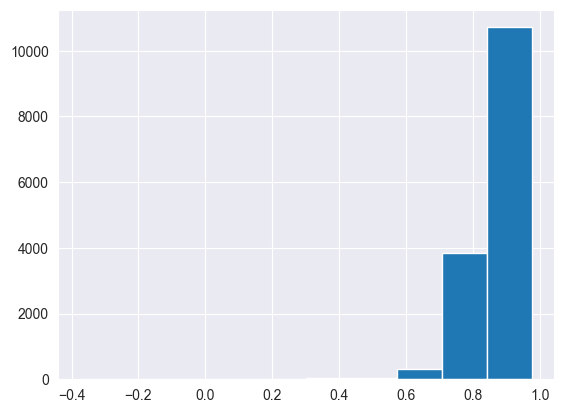

In [18]:
plt.hist(score)

(array([27., 24., 16., 16.,  8., 18.,  7., 15.,  8.,  1.]),
 array([0.        , 0.08749974, 0.17499947, 0.26249921, 0.34999895,
        0.43749868, 0.52499842, 0.61249816, 0.6999979 , 0.78749763,
        0.87499737]),
 <BarContainer object of 10 artists>)

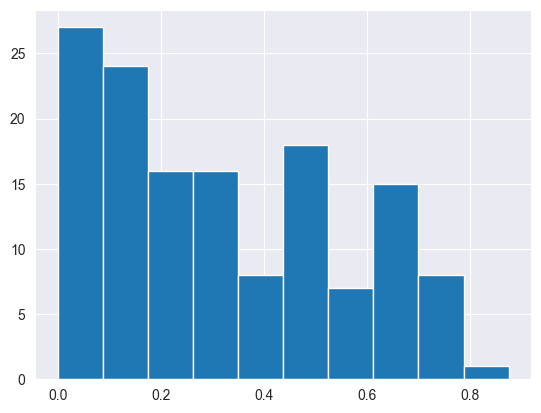

In [19]:
plt.hist(score_gene)

In [25]:
df_train_cite_targets = pd.read_hdf(return_h5_path('train_cite_targets.h5'))
df_train_cite_inputs = pd.read_hdf(return_h5_path('train_cite_inputs.h5'))

In [26]:
cite_protein_names = list(df_train_cite_targets.columns)
cite_gene_names = list(df_train_cite_inputs.columns)

In [27]:
matching_names = []

for protein in cite_protein_names:
    matching_names += [(gene, protein) for gene in cite_gene_names if protein in gene.split('_')]

matching_names = pd.DataFrame(matching_names, columns=['Gene', 'Protein'])

In [28]:
matching_names

,Gene,Protein
0,ENSG00000114013_CD86,CD86
1,ENSG00000120217_CD274,CD274
2,ENSG00000196776_CD47,CD47
3,ENSG00000117091_CD48,CD48
4,ENSG00000101017_CD40,CD40
5,ENSG00000169442_CD52,CD52
6,ENSG00000177455_CD19,CD19
7,ENSG00000105383_CD33,CD33
8,ENSG00000173762_CD7,CD7
9,ENSG00000010610_CD4,CD4


In [29]:
proteins_with_genes_indexes = []
for protein in matching_names.Protein:
    proteins_with_genes_indexes += [cite_protein_names.index(protein)]

In [30]:
score_proteins_with_genes = [0]*len(proteins_with_genes_indexes)
for i in range(0, len(proteins_with_genes_indexes) - 1):
    score_proteins_with_genes[i] = score_gene[proteins_with_genes_indexes[i]]

In [31]:
score_proteins_with_genes

[0.3482621444506207,
 0.14814771288644704,
 0.5428195908961051,
 0.7342266814999795,
 0.4658214587545406,
 0.4265877884913325,
 0.12477703756461142,
 0.4773098982809001,
 0.08319024408046152,
 0.21609695293573153,
 0.6524911425222846,
 0.15372706739291775,
 0.30457159758288715,
 0.18938478086838842,
 0.05961024510275936,
 0.5110571918296033,
 0.09165715068453974,
 0.11776455655041324,
 0.6501811693308277,
 0.05391698549287344,
 0.1041119681199647,
 0.11101824848290648,
 0.31568070395035835,
 0.5156294190890899,
 0.6732762366950127,
 0.19026133329350042,
 0.5676969713814036,
 0.7026647547779963,
 0.5026092541925562,
 0.30595634562296314,
 0.6520874335141829,
 0.1960303274958796,
 0.6781538333817525,
 0]

In [32]:
df_genes_with_proteins = []
for gene in matching_names.Gene:
    df_genes_with_proteins += [(gene, np.mean(df_train_cite_inputs[gene]), np.mean(df_train_cite_targets[gene.split('_')[1]]))]


In [154]:
df_genes_with_proteins

,gene,avg_rna,avg_protein,score
0,ENSG00000114013_CD86,0.057068,0.454768,0.348262
1,ENSG00000120217_CD274,0.049584,0.466369,0.148148
2,ENSG00000196776_CD47,3.958815,7.447880,0.542820
3,ENSG00000117091_CD48,1.891457,4.052779,0.734227
4,ENSG00000101017_CD40,0.309925,0.399293,0.465821
5,ENSG00000169442_CD52,4.481572,0.840576,0.426588
6,ENSG00000177455_CD19,0.039153,0.532907,0.124777
7,ENSG00000105383_CD33,2.045114,7.514196,0.477310
8,ENSG00000173762_CD7,0.326133,0.507866,0.083190
9,ENSG00000010610_CD4,0.242839,0.774420,0.216097


In [34]:
df_genes_with_proteins = pd.DataFrame(df_genes_with_proteins, columns = ('gene', 'avg_rna', 'avg_protein'))

In [35]:
df_genes_with_proteins['score'] = score_proteins_with_genes

In [36]:
df_genes_with_proteins

,gene,avg_rna,avg_protein,score
0,ENSG00000114013_CD86,0.057068,0.454768,0.348262
1,ENSG00000120217_CD274,0.049584,0.466369,0.148148
2,ENSG00000196776_CD47,3.958815,7.447880,0.542820
3,ENSG00000117091_CD48,1.891457,4.052779,0.734227
4,ENSG00000101017_CD40,0.309925,0.399293,0.465821
5,ENSG00000169442_CD52,4.481572,0.840576,0.426588
6,ENSG00000177455_CD19,0.039153,0.532907,0.124777
7,ENSG00000105383_CD33,2.045114,7.514196,0.477310
8,ENSG00000173762_CD7,0.326133,0.507866,0.083190
9,ENSG00000010610_CD4,0.242839,0.774420,0.216097


(0.0, 2.0)

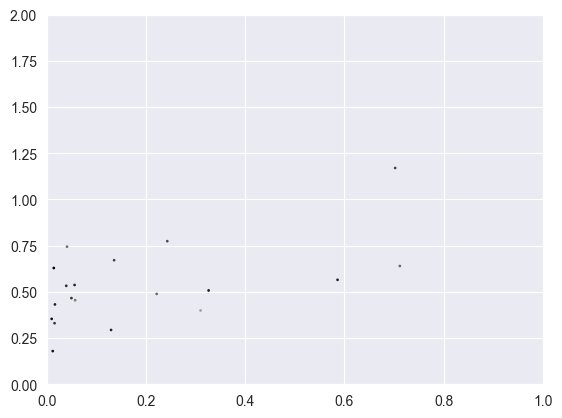

In [38]:
plt.scatter(df_genes_with_proteins.avg_rna, df_genes_with_proteins.avg_protein, s=0.9, c=df_genes_with_proteins.score, cmap='gray')

plt.xlim(0, 1)
plt.ylim(0, 2)

In [ ]:
#Dimensionality reduction

tSVD

In [109]:
#Cross-validation - take the donor id from training data, then crosscheck in metadata table for donor id

df_meta = pd.read_csv('/Users/tele/open-problems-multimodal/metadata.csv', index_col='cell_id')
df_meta_cite = df_meta[df_meta.technology=="citeseq"]
#df_meta_cite = df_meta_cite[df_meta_cite.day!=10]
df_meta_cite = df_meta_cite[df_meta_cite.day!=7]
df_meta_cite_cv =  df_meta_cite[df_meta_cite.day==4]
df_meta_cite_train =  df_meta_cite[df_meta_cite.day!=4]

In [145]:
#df_meta_cite_cv.index
#train_cite_inputs_data
#df_meta_cite.day
df_meta_cite_train.index[1]
df_train_cite_inputs.loc[df_meta_cite_train.index[50000]]
df_train_cite_inputs.index

Index(['45006fe3e4c8', 'd02759a80ba2', 'c016c6b0efa5', 'ba7f733a4f75',
       'fbcf2443ffb2', 'd80d84ca8e89', '1ac2049b4c98', '33fb0c29e2e4',
       'b329261bd0ee', '703762287e88',
       ...
       'f901120ab887', 'e3780c598532', '663da056425f', '10b466d6898b',
       '4d22a430b2b8', '650ee456f0f3', 'cc506e7707f5', 'a91f1b55a520',
       '3a9882c98205', 'c91b6b2ccd3d'],
      dtype='object', name='cell_id', length=70988)

In [1]:
#Either make two diff dfs for train and cv or add a column with days at the end
#cite_train_set = pd.DataFrame(columns=df_train_cite_inputs.columns)
#cite_cv_set = pd.DataFrame(columns=df_train_cite_inputs.columns)
#for i in range(0, len(df_meta_cite_train)-1):
 #   if df_meta_cite_train.index[i] in df_train_cite_inputs.index:
  #      cite_train_set = pd.concat([cite_train_set, df_train_cite_inputs.loc[df_meta_cite_train.index[i]].to_frame().T])
   # else:
    #    print(f'{i} is not in list')

In [178]:
df_train_cite_inputs.loc[df_meta_cite_train.index[15000]].to_frame().T

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
43f4024ab679,0.0,0.0,0.0,0.0,0.0,0.0,3.261203,3.934993,0.0,3.934993,...,0.0,3.261203,3.261203,4.618319,0.0,0.0,0.0,0.0,0.0,3.261203


In [173]:
df_train_cite_inputs.loc[df_meta_cite_train.index[15000]]

gene_id
ENSG00000121410_A1BG        0.000000
ENSG00000268895_A1BG-AS1    0.000000
ENSG00000175899_A2M         0.000000
ENSG00000245105_A2M-AS1     0.000000
ENSG00000166535_A2ML1       0.000000
                              ...   
ENSG00000198455_ZXDB        0.000000
ENSG00000070476_ZXDC        0.000000
ENSG00000162378_ZYG11B      0.000000
ENSG00000159840_ZYX         0.000000
ENSG00000074755_ZZEF1       3.261203
Name: 43f4024ab679, Length: 22050, dtype: float32

In [179]:
cite_train_set

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1


In [165]:
df_meta_cite_train.index

Index(['c2150f55becb', '65b7edf8a4da', 'c1b26cb1057b', '917168fa6f83',
       '2b29feeca86d', '0fd801488185', '526647a698f8', 'ab8f207a3dec',
       '57f730249c87', '08df3dcce25c',
       ...
       'f39651a917eb', 'c32679d7f1d0', '763fcb1c53eb', 'a8e462a6198d',
       '41f5809b67d1', '0169f964147e', '7203b2ace768', '834449e1a23d',
       '769790e1b39a', 'e7012ac38766'],
      dtype='object', name='cell_id', length=56807)

In [166]:
df_train_cite_inputs.index

Index(['45006fe3e4c8', 'd02759a80ba2', 'c016c6b0efa5', 'ba7f733a4f75',
       'fbcf2443ffb2', 'd80d84ca8e89', '1ac2049b4c98', '33fb0c29e2e4',
       'b329261bd0ee', '703762287e88',
       ...
       'f901120ab887', 'e3780c598532', '663da056425f', '10b466d6898b',
       '4d22a430b2b8', '650ee456f0f3', 'cc506e7707f5', 'a91f1b55a520',
       '3a9882c98205', 'c91b6b2ccd3d'],
      dtype='object', name='cell_id', length=70988)

In [69]:
df_train_cite_inputs

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000
